# **PROJECT 4: HOME LOAN DATA ANALYSIS**

### **Objective**: Create a model that predicts whether or not an applicant will be able to repay a loan using historical data.

Import relevant libraries

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

%matplotlib inline

***
## **Step 1 - Data Preprocessing**

Load the dataset

In [2]:
data = pd.read_csv('loan_data.csv')

Exploratory data analysis

In [3]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


Drop irrelevant columns

In [5]:
# Load data dictionary to gain column description
data_description = pd.read_csv('Data_Dictionary.csv', encoding='ISO 8859-1')

In [6]:
data_description.count()
for col in data.columns:
    print(f"'{col}',")

'SK_ID_CURR',
'TARGET',
'NAME_CONTRACT_TYPE',
'CODE_GENDER',
'FLAG_OWN_CAR',
'FLAG_OWN_REALTY',
'CNT_CHILDREN',
'AMT_INCOME_TOTAL',
'AMT_CREDIT',
'AMT_ANNUITY',
'AMT_GOODS_PRICE',
'NAME_TYPE_SUITE',
'NAME_INCOME_TYPE',
'NAME_EDUCATION_TYPE',
'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE',
'REGION_POPULATION_RELATIVE',
'DAYS_BIRTH',
'DAYS_EMPLOYED',
'DAYS_REGISTRATION',
'DAYS_ID_PUBLISH',
'OWN_CAR_AGE',
'FLAG_MOBIL',
'FLAG_EMP_PHONE',
'FLAG_WORK_PHONE',
'FLAG_CONT_MOBILE',
'FLAG_PHONE',
'FLAG_EMAIL',
'OCCUPATION_TYPE',
'CNT_FAM_MEMBERS',
'REGION_RATING_CLIENT',
'REGION_RATING_CLIENT_W_CITY',
'WEEKDAY_APPR_PROCESS_START',
'HOUR_APPR_PROCESS_START',
'REG_REGION_NOT_LIVE_REGION',
'REG_REGION_NOT_WORK_REGION',
'LIVE_REGION_NOT_WORK_REGION',
'REG_CITY_NOT_LIVE_CITY',
'REG_CITY_NOT_WORK_CITY',
'LIVE_CITY_NOT_WORK_CITY',
'ORGANIZATION_TYPE',
'EXT_SOURCE_1',
'EXT_SOURCE_2',
'EXT_SOURCE_3',
'APARTMENTS_AVG',
'BASEMENTAREA_AVG',
'YEARS_BEGINEXPLUATATION_AVG',
'YEARS_BUILD_AVG',
'COMMONAREA_AVG',
'ELEV

For this assignment, we are trying to determine if an individual can repay a loan. Since there are 120 columns (122 in original Dataframe but the three EXT_SOURCE's are grouped together), many of which have little to no relevance with finance, informative descriptions will be printed for each column to determine how relevant the variable is to the problem.

In [7]:
num_rows = data_description.shape[0]

for i in range(num_rows):
    print(i, data_description['Variable Name'][i])
    print(data_description['Description'][i])
    print()

0 SK_ID_CURR
Unique identifier for each client.

1 TARGET
Whether the loan was repaid (1 for yes, 0 for no).

2 NAME_CONTRACT_TYPE
Type of loan contract (e.g., Cash loans, Revolving loans).

3 CODE_GENDER
Gender of the applicant.

4 FLAG_OWN_CAR
Whether the applicant owns a car (Yes/No).

5 FLAG_OWN_REALTY
Whether the applicant owns a house or flat (Yes/No).

6 CNT_CHILDREN
Number of children the applicant has.

7 AMT_INCOME_TOTAL
Total income of the applicant.

8 AMT_CREDIT
Total credit amount of the loan.

9 AMT_ANNUITY
Loan annuity (monthly payment).

10 AMT_GOODS_PRICE
Price of the goods for which the loan is taken.

11 NAME_TYPE_SUITE
Who was accompanying the client when applying for the loan.

12 NAME_INCOME_TYPE
Income category of the applicant (e.g., Working, Pensioner).

13 NAME_EDUCATION_TYPE
Education level of the applicant.

14 NAME_FAMILY_STATUS
Family status of the applicant (e.g., Married, Single).

15 NAME_HOUSING_TYPE
Housing situation of the applicant (e.g., Rented ap

**Observations**:
- There are many variables that are extraneous and unnecessary for our purposes.
    - For example, 'NAME_TYPE_SUITE' represents the name of the person accompanying the client when applying for the loan. This variable does not seem to affect the client's ability to repay a loan. Therefore, this column will be dropped.
    - Most variables that will be dropped pertain to application details that do not have any relation to the client's financial status
- However, variables such as 'FLAG_OWN_CAR' and 'AMT_CREDIT' do contribute to the financial status of the client and thus will not be dropped.

In [8]:
# Create a list of columns to drop based on their descriptions and relevance to the project
columns_to_drop = ['SK_ID_CURR',
                   'NAME_TYPE_SUITE',
                   'OWN_CAR_AGE',
                   'FLAG_MOBIL',
                   'FLAG_EMP_PHONE',
                   'FLAG_WORK_PHONE',
                   'FLAG_CONT_MOBILE',
                   'FLAG_PHONE',
                   'FLAG_EMAIL',
                   'WEEKDAY_APPR_PROCESS_START',
                   'HOUR_APPR_PROCESS_START',
                   'REG_REGION_NOT_LIVE_REGION',
                   'LIVE_REGION_NOT_WORK_REGION',
                   'REG_CITY_NOT_LIVE_CITY',
                   'LIVE_CITY_NOT_WORK_CITY',

                   # Drop mode values for these variables because average values are kept
                   'APARTMENTS_MODE',
                   'BASEMENTAREA_MODE',
                   'YEARS_BEGINEXPLUATATION_MODE',
                   'YEARS_BUILD_MODE',
                   'COMMONAREA_MODE',
                   'ELEVATORS_MODE',
                   'ENTRANCES_MODE',
                   'FLOORSMAX_MODE',
                   'FLOORSMIN_MODE',
                   'LANDAREA_MODE',
                   'LIVINGAPARTMENTS_MODE',
                   'LIVINGAREA_MODE',
                   'NONLIVINGAPARTMENTS_MODE',
                   'NONLIVINGAREA_MODE',
                   
                   # Drop median values for these variables because average values are kept
                   'APARTMENTS_MEDI',
                   'BASEMENTAREA_MEDI',
                   'YEARS_BEGINEXPLUATATION_MEDI',
                   'YEARS_BUILD_MEDI',
                   'COMMONAREA_MEDI',
                   'ELEVATORS_MEDI',
                   'ENTRANCES_MEDI',
                   'FLOORSMAX_MEDI',
                   'FLOORSMIN_MEDI',
                   'LANDAREA_MEDI',
                   'LIVINGAPARTMENTS_MEDI',
                   'LIVINGAREA_MEDI',
                   'NONLIVINGAPARTMENTS_MEDI',
                   'NONLIVINGAREA_MEDI',

                   'OBS_30_CNT_SOCIAL_CIRCLE',
                   'DEF_30_CNT_SOCIAL_CIRCLE',
                   'OBS_60_CNT_SOCIAL_CIRCLE',
                   'DEF_60_CNT_SOCIAL_CIRCLE',
                   'DAYS_LAST_PHONE_CHANGE']

In [9]:
data = data.drop(columns=columns_to_drop, axis=1)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307511 non-null  int64  
 1   NAME_CONTRACT_TYPE           307511 non-null  object 
 2   CODE_GENDER                  307511 non-null  object 
 3   FLAG_OWN_CAR                 307511 non-null  object 
 4   FLAG_OWN_REALTY              307511 non-null  object 
 5   CNT_CHILDREN                 307511 non-null  int64  
 6   AMT_INCOME_TOTAL             307511 non-null  float64
 7   AMT_CREDIT                   307511 non-null  float64
 8   AMT_ANNUITY                  307499 non-null  float64
 9   AMT_GOODS_PRICE              307233 non-null  float64
 10  NAME_INCOME_TYPE             307511 non-null  object 
 11  NAME_EDUCATION_TYPE          307511 non-null  object 
 12  NAME_FAMILY_STATUS           307511 non-null  object 
 13 

Check for null values

In [11]:
# Compute percentage of missing data
null_values = data.isnull().apply(lambda x: round(x.sum() / data.shape[0] * 100, 1).astype('str') + '%')
null_values = null_values[null_values != '0.0%']

print('PERCENTAGE OF DATA MISSING:')
null_values

PERCENTAGE OF DATA MISSING:


AMT_GOODS_PRICE                 0.1%
OCCUPATION_TYPE                31.3%
EXT_SOURCE_1                   56.4%
EXT_SOURCE_2                    0.2%
EXT_SOURCE_3                   19.8%
APARTMENTS_AVG                 50.7%
BASEMENTAREA_AVG               58.5%
YEARS_BEGINEXPLUATATION_AVG    48.8%
YEARS_BUILD_AVG                66.5%
COMMONAREA_AVG                 69.9%
ELEVATORS_AVG                  53.3%
ENTRANCES_AVG                  50.3%
FLOORSMAX_AVG                  49.8%
FLOORSMIN_AVG                  67.8%
LANDAREA_AVG                   59.4%
LIVINGAPARTMENTS_AVG           68.4%
LIVINGAREA_AVG                 50.2%
NONLIVINGAPARTMENTS_AVG        69.4%
NONLIVINGAREA_AVG              55.2%
FONDKAPREMONT_MODE             68.4%
HOUSETYPE_MODE                 50.2%
TOTALAREA_MODE                 48.3%
WALLSMATERIAL_MODE             50.8%
EMERGENCYSTATE_MODE            47.4%
AMT_REQ_CREDIT_BUREAU_HOUR     13.5%
AMT_REQ_CREDIT_BUREAU_DAY      13.5%
AMT_REQ_CREDIT_BUREAU_WEEK     13.5%
A

**Observations**:
- While the dataset is very large, there is a large amount of missing data.
- Apartment specifications and information is responsible for most of the null values.
- Since many of the columns exceed 50% of missing entries, it would be harmful to drop all the rows with null values.

Handle null values by imputation

In [12]:
# Handle null values based on column type
for col in data.columns:
    if data[col].dtype == 'object':
        # Imputate categorical data with mode
        mode = data[col].mode()[0]
        data[col].fillna(mode, inplace=True)
    else:
        # Imputate numerical data with mean
        mean = data[col].mean()
        data[col].fillna(mean, inplace=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1012096107.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(mean, inplace=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1012096107.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

In [13]:
data.isna().sum()

TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 74, dtype: int64

## **Step 2: Exploratory Data Analysis**

### **UNIVARIATE ANALYSIS**
- Categorical:
    - TARGET
    - NAME_CONTRACT_TYPE
    - CODE_GENDER
    - NAME_INCOME_TYPE
    - NAME_EDUCATION_TYPE
    - NAME_HOUSING_TYPE
    - OCCUPATION_TYPE
    - ORGANIZATION_TYPE
- Numerical:
    - CMT_CHILDREN
    - AMT_INCOME_TOTAL
    - AMT_CREDIT
    - AMT_ANNUITY

Define helper function for plotting distribution plots

In [14]:
# Used for categorical variables
def plot_bar(col, labelsize=10, flip=False):
    var = data[col].value_counts()

    if flip:
        sns.barplot(x=var.values, y=var.index, palette='bright')
    else:
        sns.barplot(x=var.index, y=var.values, palette='bright')

    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Number of People')
    plt.tick_params(labelsize=labelsize)
    
    return var    

#### Plot Histogram of Target (categorical)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.index, y=var.values, palette='bright')


TARGET
0    282686
1     24825
Name: count, dtype: int64

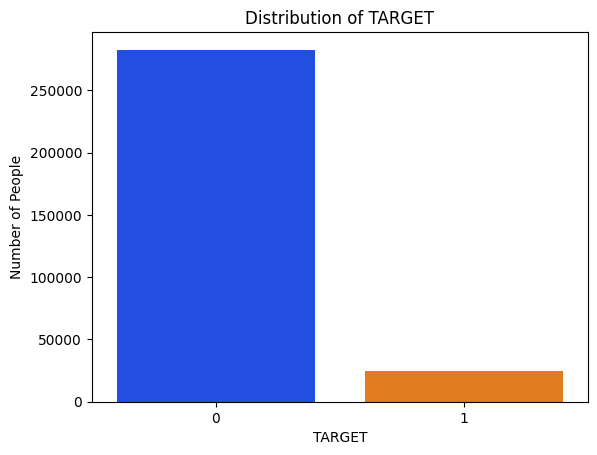

In [ ]:
plot_bar('TARGET')

**Observation**: The dataset is unbalanced. For the target feature, 91.9% of clients were unable to repay their loan while only 8.1% of clients were able to repay their loan. SMOTE will be used to upsample the minority class after performing EDA.

#### Plot Histogram of Loan Contract Type (categorical)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.index, y=var.values, palette='bright')


NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

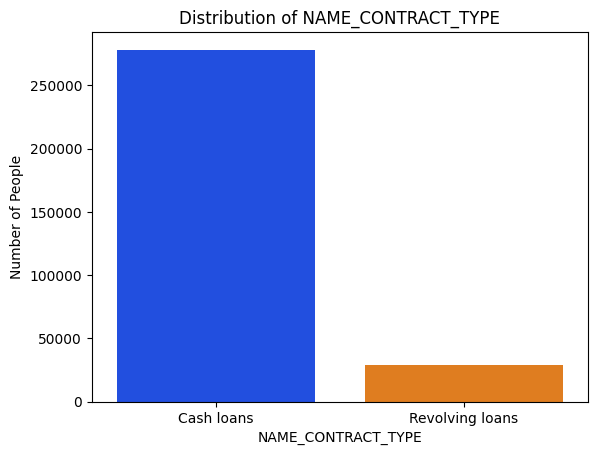

In [16]:
plot_bar('NAME_CONTRACT_TYPE')

**Observation(s)**:
- The distribution plot shows that the majority of loan contracts are cash loans

#### Plot Histogram of Gender (categorical)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.index, y=var.values, palette='bright')


CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

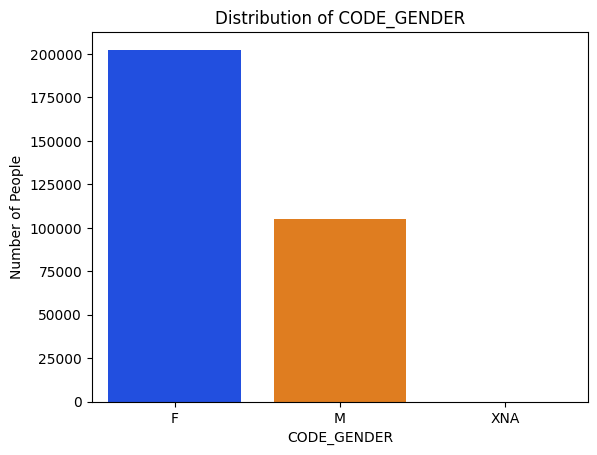

In [17]:
plot_bar('CODE_GENDER')

**Observation(s)**:
- The distribution plot shows that the majority of clients are female
- There is nearly double the amount of female applicants compared to male applicants with very few XNA applicants

#### Plot Histogram of Income Type (categorical)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.values, y=var.index, palette='bright')


NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

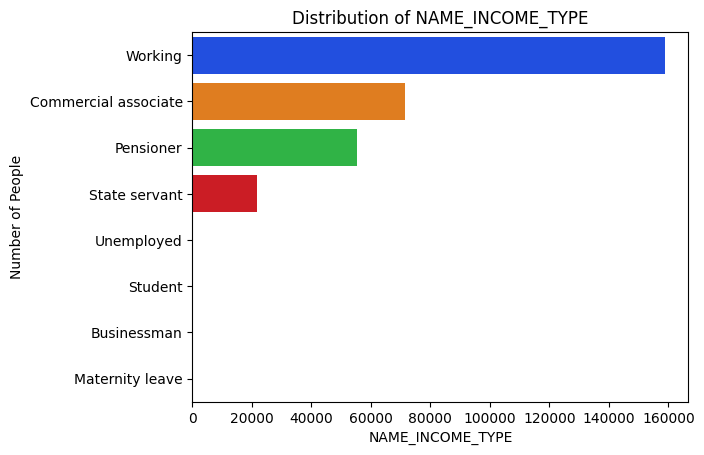

In [18]:
plot_bar('NAME_INCOME_TYPE', flip=True)

**Observation(s)**:
- The distribution plot shows that the majority of clients are working class
- The most prominent income types are working, commerical associate, pensioner, and state servant
- There are very few clients that are unemployed, students, businessman, or on maternity leave

#### Plot Histogram of Education Type (categorical)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.values, y=var.index, palette='bright')


NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64

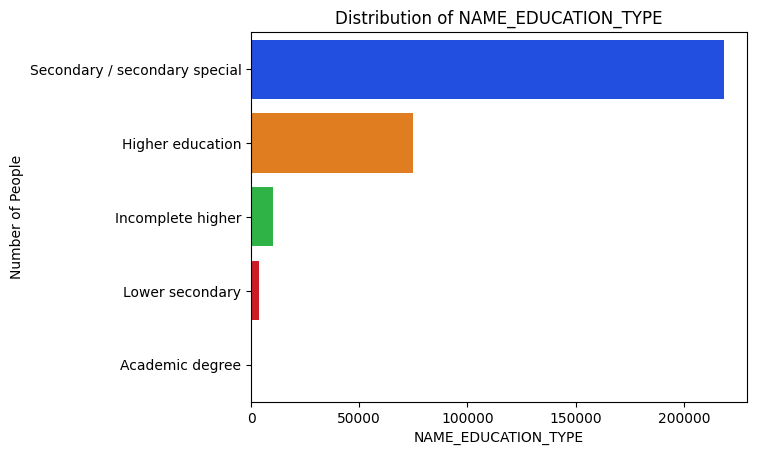

In [19]:
plot_bar('NAME_EDUCATION_TYPE', flip=True)

**Observation(s)**:
- The distribution plot shows that the majority of clients have completed secondary education
- The most prominent education types are secondary education and higher education
- There are very few clients that have an incomplete higher education, lower secondary education, or academic degree

#### Plot Histogram of Housing Type (categorical)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.values, y=var.index, palette='bright')


NAME_HOUSING_TYPE
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64

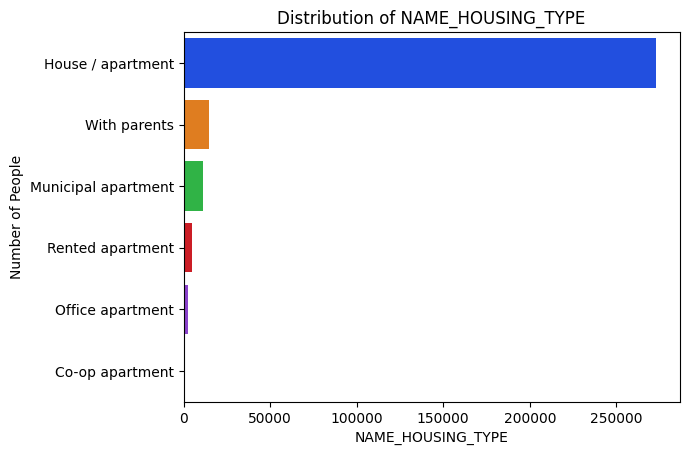

In [20]:
plot_bar('NAME_HOUSING_TYPE', flip=True)

**Observation(s)**:
- The distribution plot shows that the majority of clients live in a house/apartment
- The most common housing types are house/apartment, with parents, and municipal apartment
- There are very few clients that live in a co-op apartment

#### Plot Histogram of Occupation Type (categorical)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.values, y=var.index, palette='bright')


OCCUPATION_TYPE
Laborers                 151577
Sales staff               32102
Core staff                27570
Managers                  21371
Drivers                   18603
High skill tech staff     11380
Accountants                9813
Medicine staff             8537
Security staff             6721
Cooking staff              5946
Cleaning staff             4653
Private service staff      2652
Low-skill Laborers         2093
Waiters/barmen staff       1348
Secretaries                1305
Realty agents               751
HR staff                    563
IT staff                    526
Name: count, dtype: int64

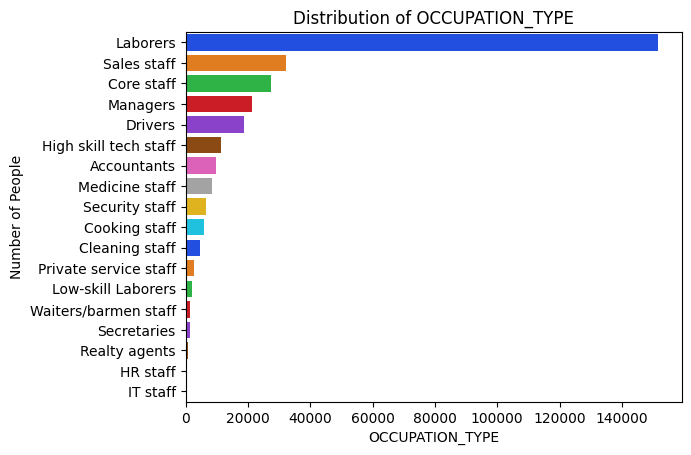

In [21]:
plot_bar('OCCUPATION_TYPE', flip=True)

**Observation(s)**:
- The distribution plot shows that the majority of clients are laborers
- The most common occupation types are laborers, sales staff, core staff, managers, and driver
- There are very few clients that are HR staff or IT staff

#### Plot Histogram of Organization Type (categorical)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.values, y=var.index, palette='bright')


ORGANIZATION_TYPE
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

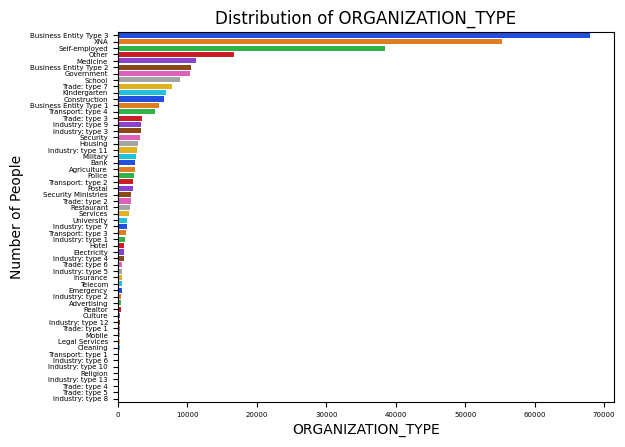

In [22]:
plot_bar('ORGANIZATION_TYPE', labelsize=5, flip=True)

**Observation(s)**:
- The distribution plot shows that the majority of clients are business entity type 3, XNA, or self-employed
- There are very few clients that work in mobile, legal services, cleaning, relgion, and higher industry type jobs

#### Plot Histogram of Children Count (numerical)

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.index, y=var.values, palette='bright')


CNT_CHILDREN
0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: count, dtype: int64

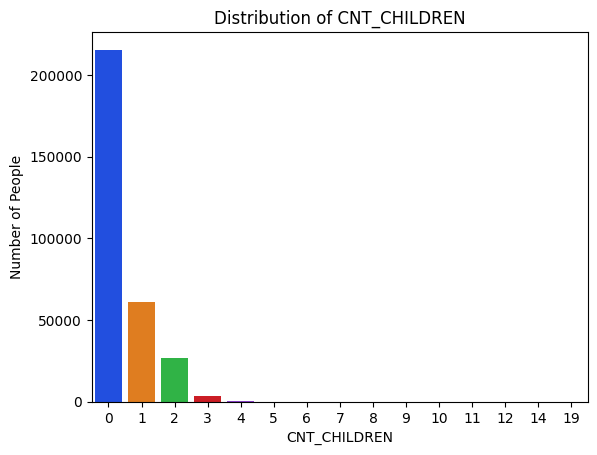

In [23]:
plot_bar('CNT_CHILDREN')

**Observation(s)**:
- The distribution plot shows that the majority of applicants have no children
- Left skew distribution
- There are few entries for clients with 4 or more children

#### Plot Boxplot of Total Income (numerical)

Text(0, 0.5, 'Total Income')

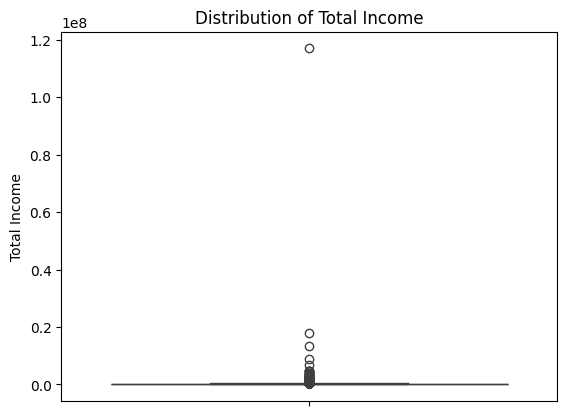

In [24]:
total_income = data['AMT_INCOME_TOTAL']

# Box Plot of Total Income
sns.boxplot(total_income)
plt.title(f'Distribution of Total Income')
plt.ylabel('Total Income')

**Observation(s)**:
- It is difficult to interpret this data since there are several outliers that skew the data
- To make the boxplot more readable, the outliers will be removed

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

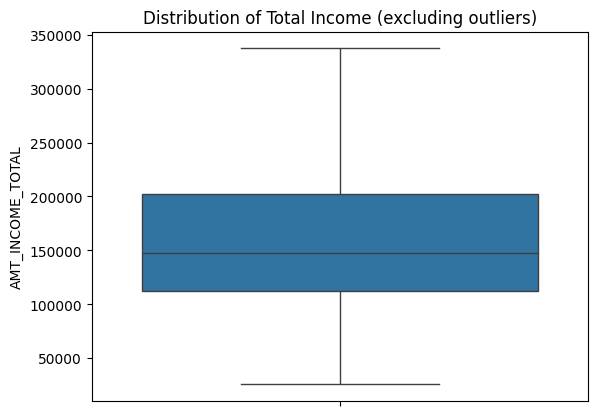

In [25]:
# Removing outliers
sns.boxplot(total_income, showfliers=False)
plt.title(f'Distribution of Total Income (excluding outliers)')

total_income.describe()

**Observation(s)**:
- The boxplot and statistics show that the median income is 147150 and the mean income is about 168800
- Most clients' income lie within 112500 to 202500
- The outlier responsible for the extreme skewing has an income of 117000000

#### Plot Boxplot of Credit (numerical)

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

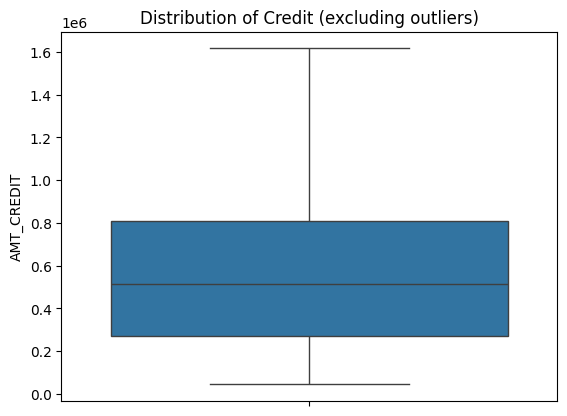

In [26]:
credit = data['AMT_CREDIT']

sns.boxplot(credit, showfliers=False)
plt.title(f'Distribution of Credit (excluding outliers)')

credit.describe()

**Observation(s)**:
- The boxplot and statistics show that the median income is 5135310 and the mean income is about 599026
- Most clients' income lie within 270000 to 808650
- The outlier responsible for the extreme skewing has an income of 4050000

#### Plot Boxplot of Annuity (numerical)

count    307511.000000
mean      27108.573909
std       14493.454517
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

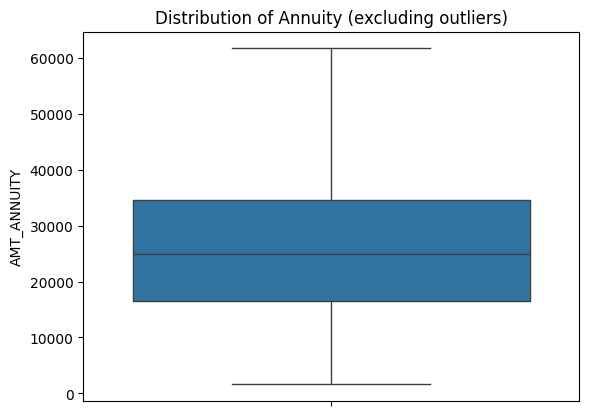

In [27]:
annuity = data['AMT_ANNUITY']

sns.boxplot(annuity, showfliers=False)
plt.title(f'Distribution of Annuity (excluding outliers)')

annuity.describe()

**Observation(s)**:
- The boxplot and statistics show that the median income is 24903 and the mean income is about 27109
- Most clients' income lie within 16524 to 34596
- The outlier responsible for the extreme skewing has an income of 258025

### **BIVARIATE/MULTIVARIATE ANALYSIS**

#### Countplot of target across contract type

Text(0.5, 1.0, 'Countplot of target across contract type')

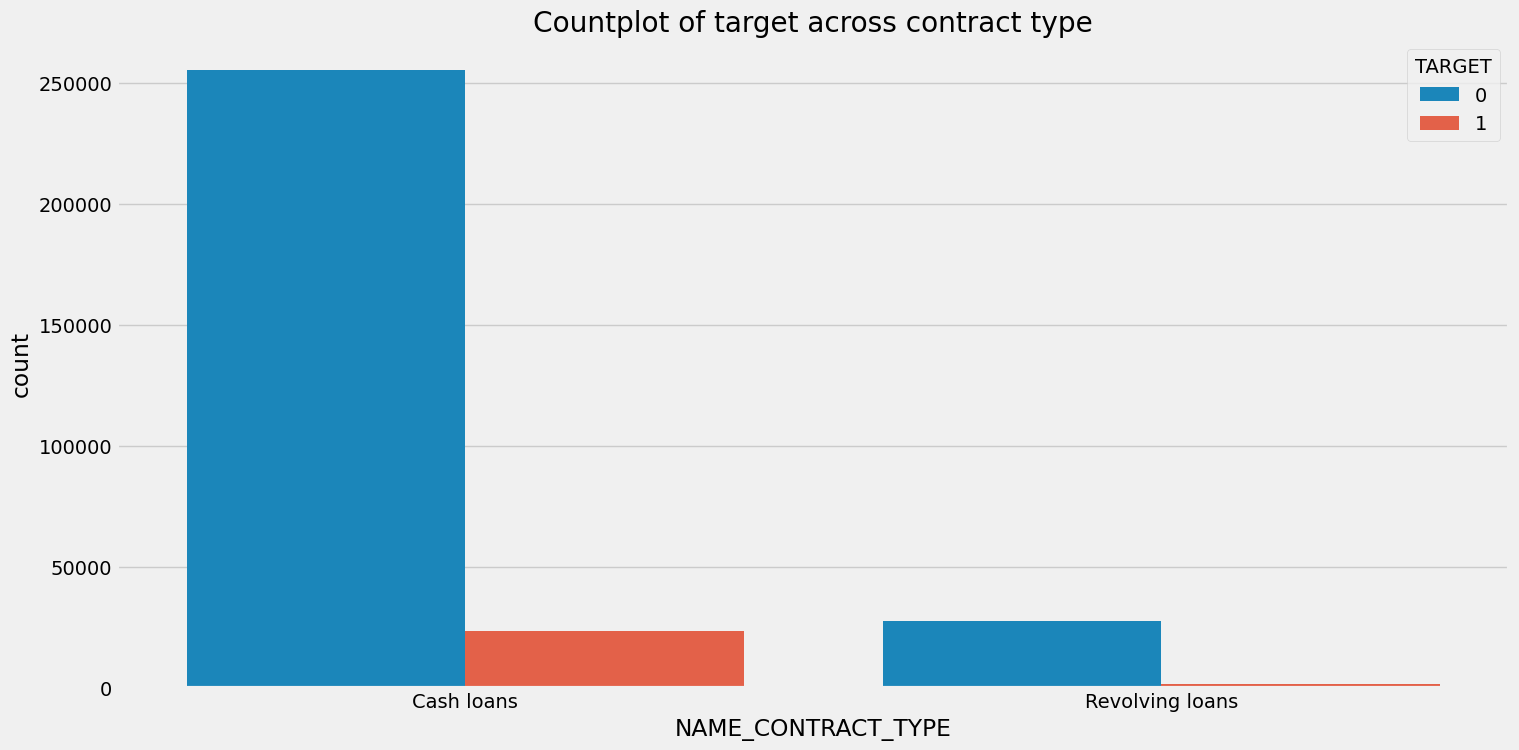

In [28]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))

sns.countplot(x=data['NAME_CONTRACT_TYPE'], hue=data['TARGET'])
plt.title('Countplot of target across contract type')

**Observation**:
- The countplot of target across contract type shows that a larger proportion of cash loans were paid back compared to revolving loans

#### Countplot of target across gender

Text(0.5, 1.0, 'Countplot of target across gender')

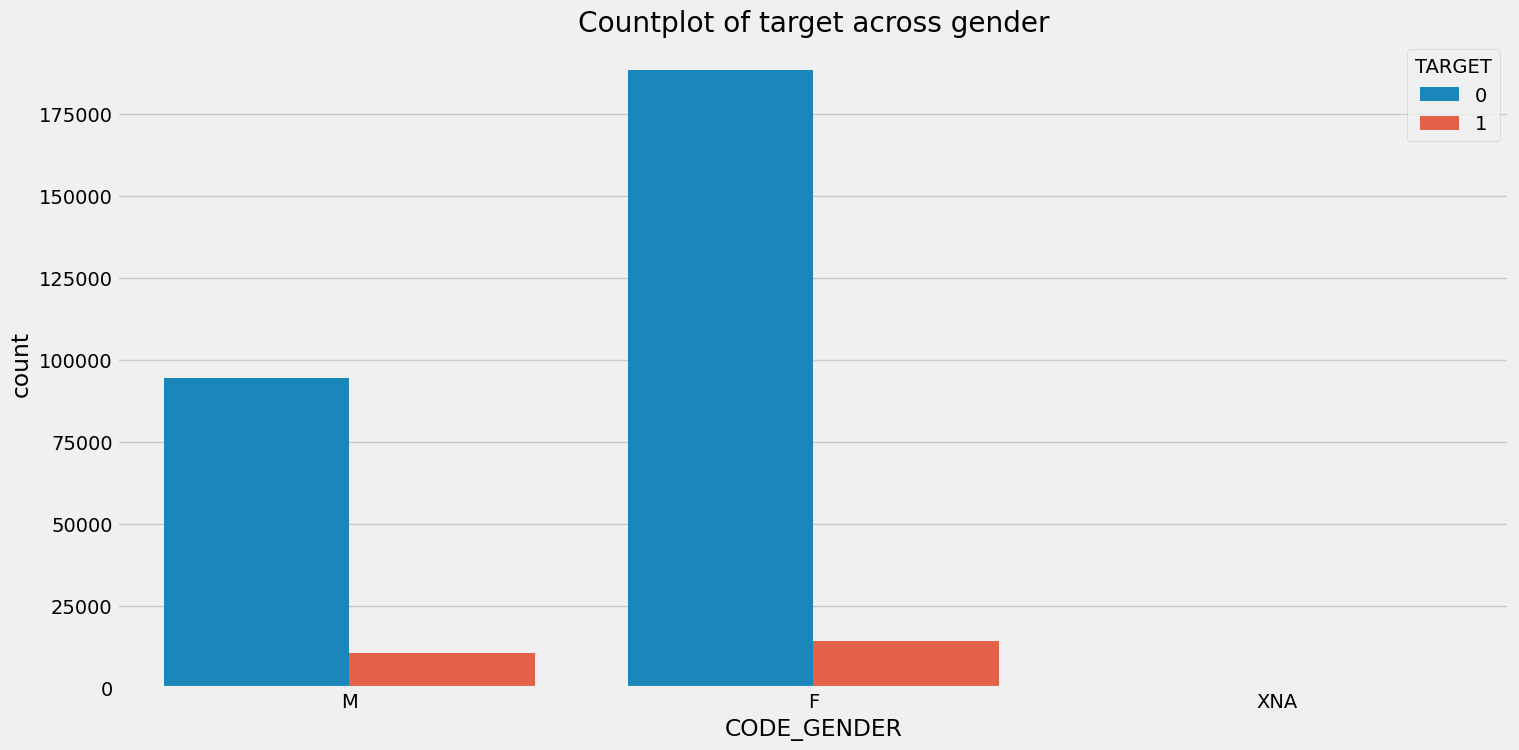

In [29]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))

sns.countplot(x=data['CODE_GENDER'], hue=data['TARGET'])
plt.title('Countplot of target across gender')

**Observation**:
- The countplot of target across gender does not show any significant correlation between these two variables

#### Countplot of target across income type

Text(0.5, 1.0, 'Countplot of target across income type')

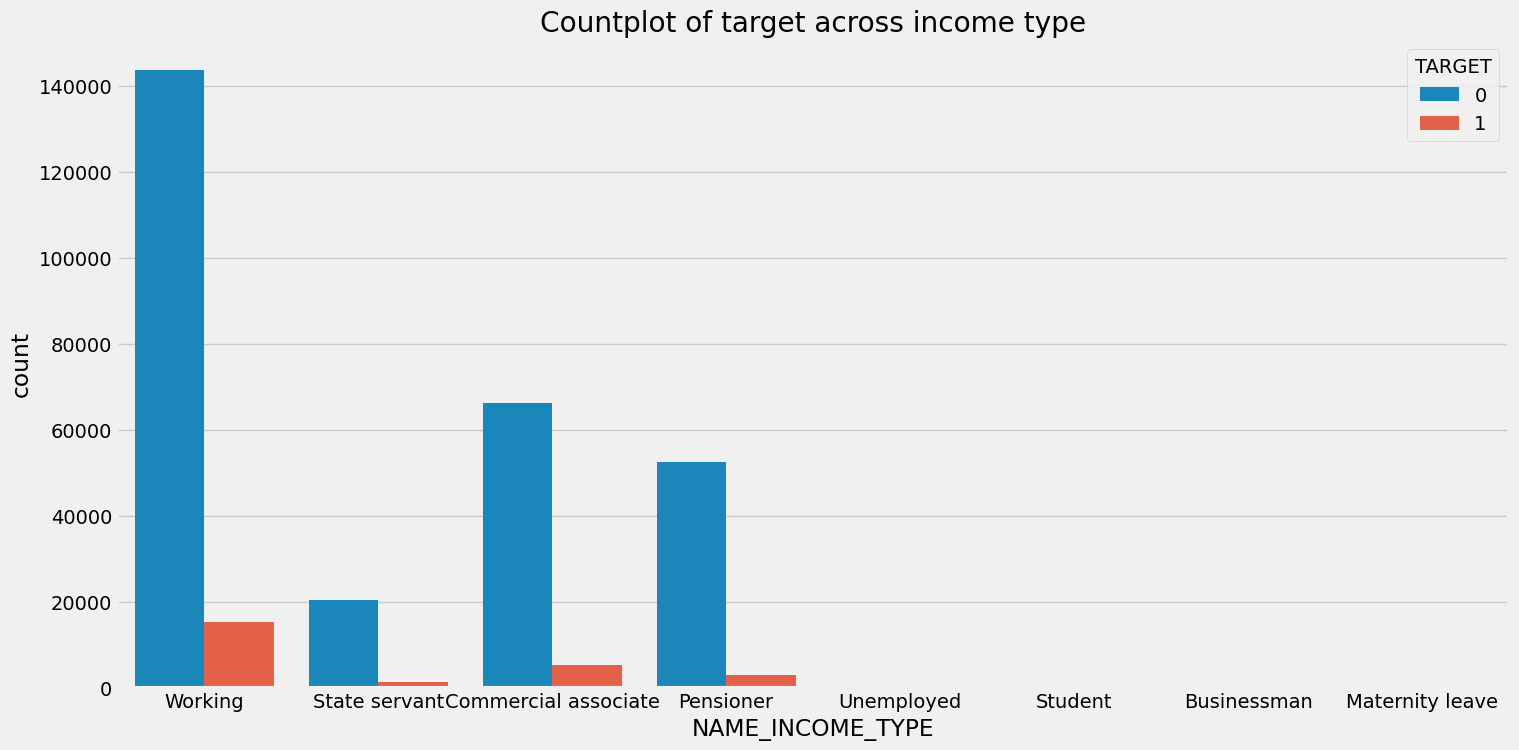

In [30]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))

sns.countplot(x=data['NAME_INCOME_TYPE'], hue=data['TARGET'])
plt.title('Countplot of target across income type')

**Observation**:
- The countplot of target across income type does not show any significant correlation between these two variables

#### Countplot of target across education type

Text(0.5, 1.0, 'Countplot of target across education type')

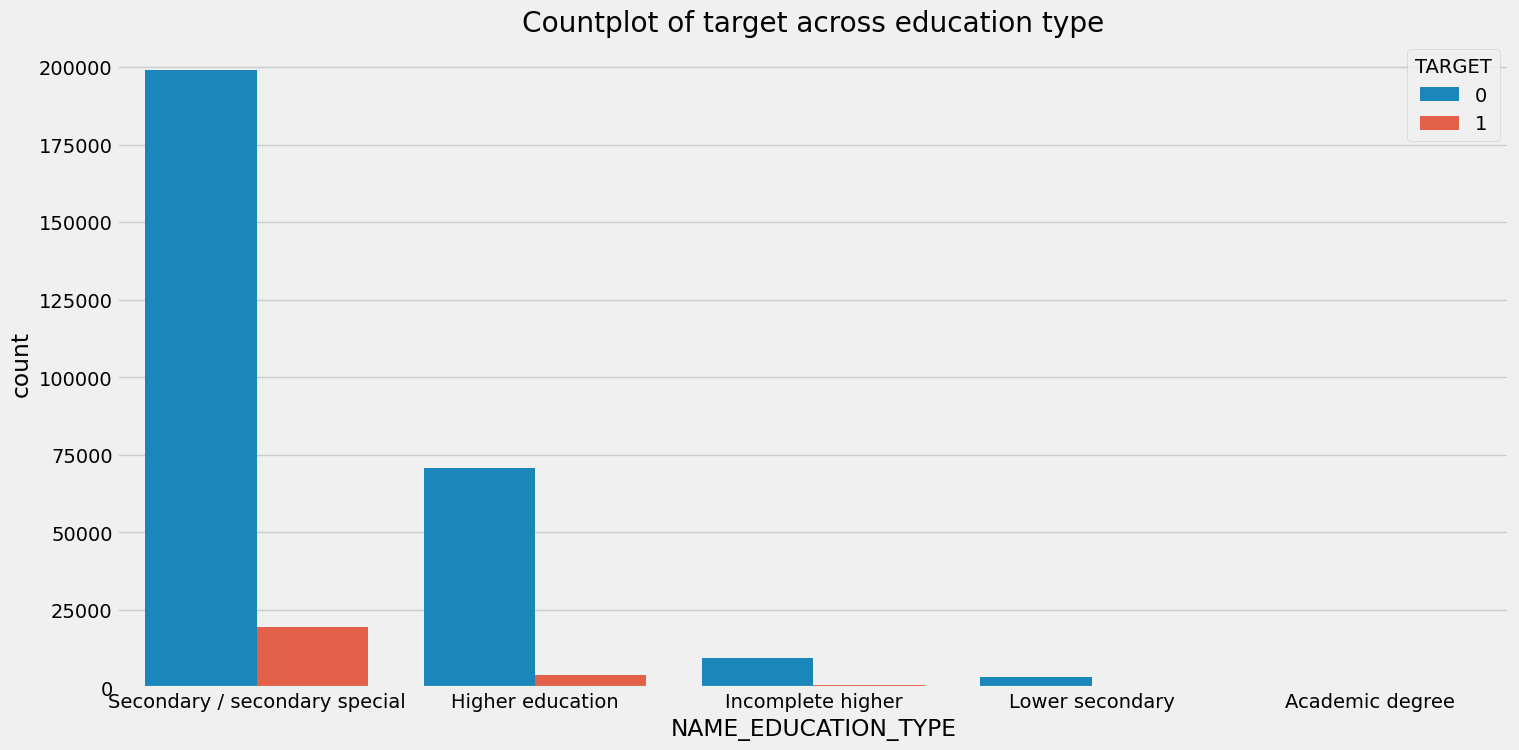

In [31]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))

sns.countplot(x=data['NAME_EDUCATION_TYPE'], hue=data['TARGET'])
plt.title('Countplot of target across education type')

**Observation**:
- The countplot of target across income type does not show any significant correlation between these two variables

#### Countplot of target across housing type

Text(0.5, 1.0, 'Countplot of target across housing type')

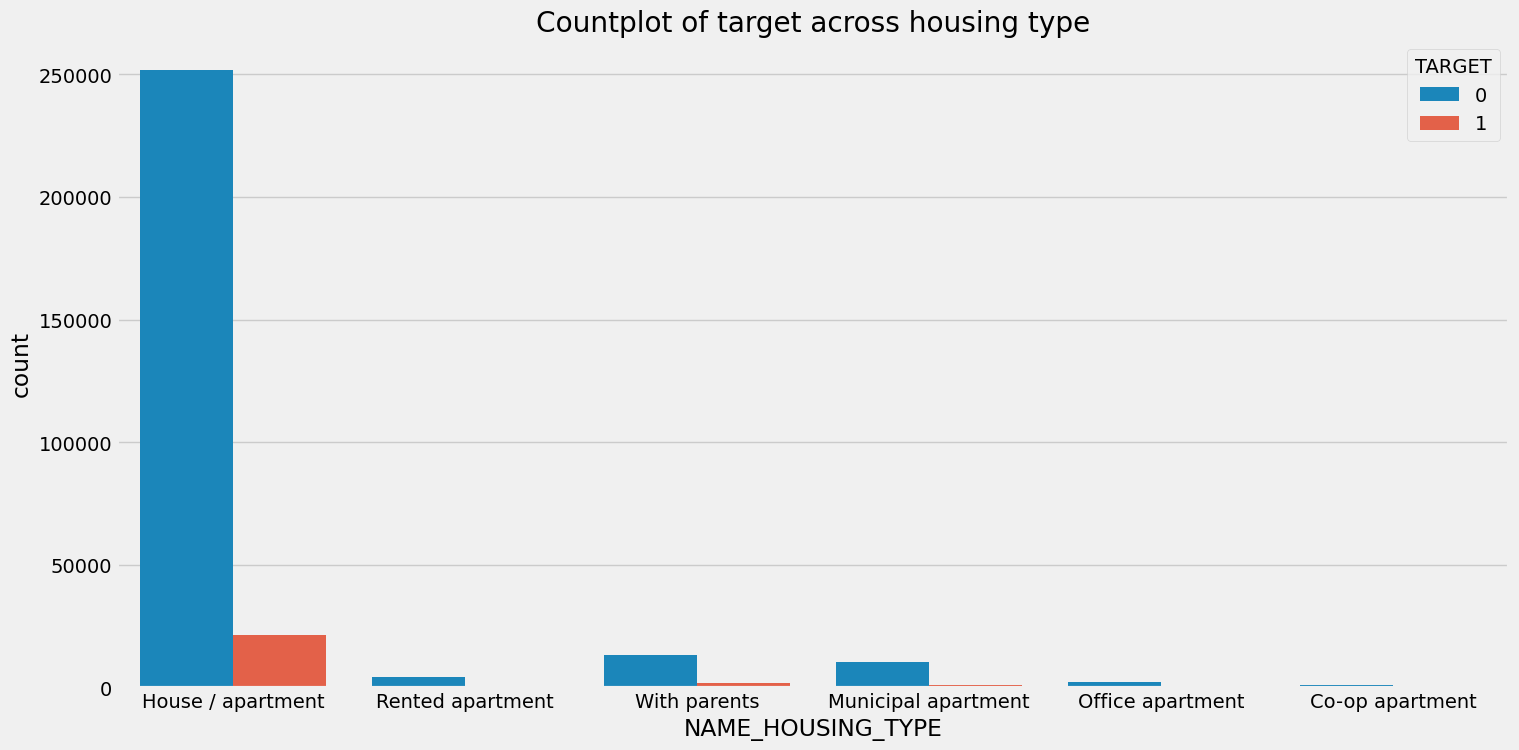

In [32]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))

sns.countplot(x=data['NAME_HOUSING_TYPE'], hue=data['TARGET'])
plt.title('Countplot of target across housing type')

**Observation**:
- The countplot of target across housing type does not show any significant correlation between these two variables

#### Countplot of target across orgnaization type

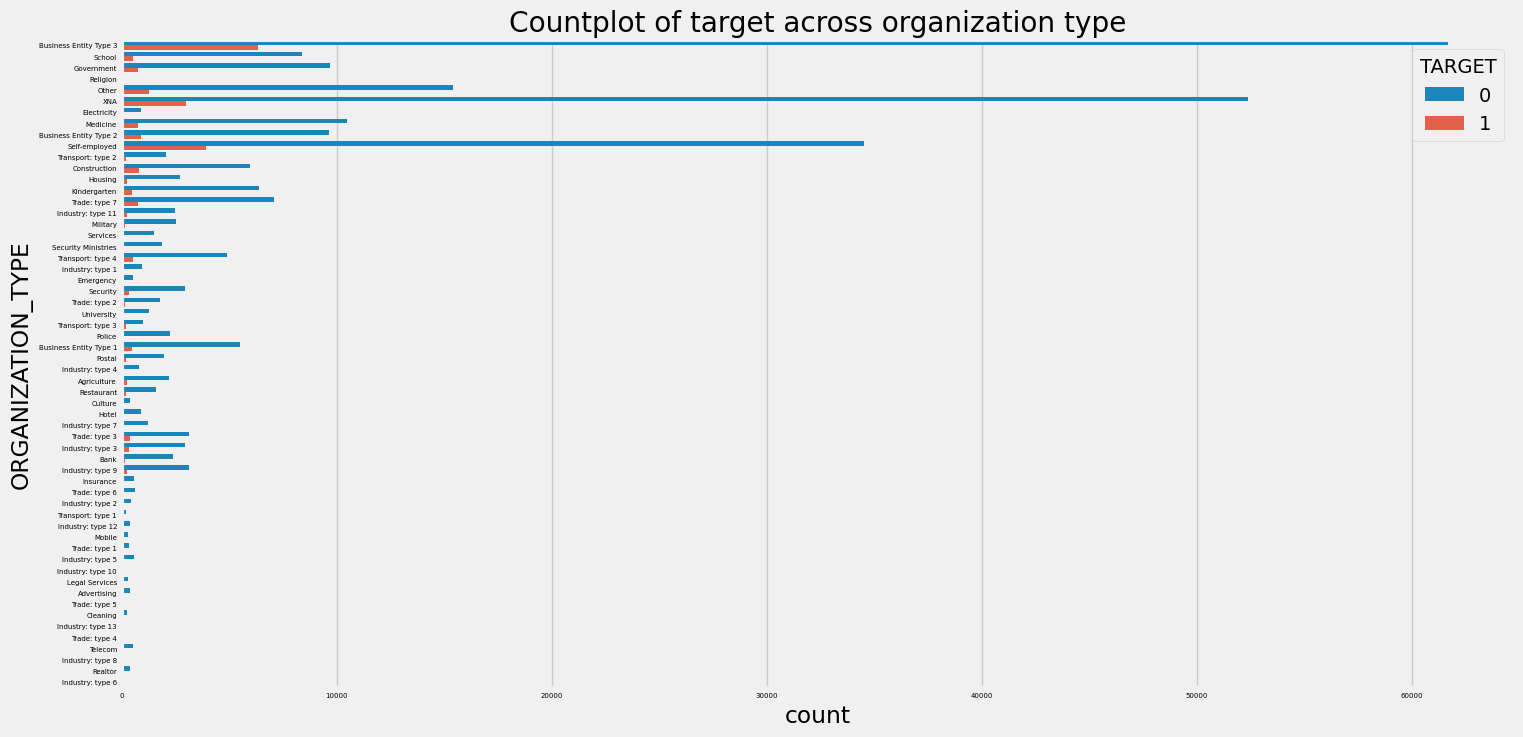

In [33]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))

sns.countplot(y=data['ORGANIZATION_TYPE'], hue=data['TARGET'])
plt.title('Countplot of target across organization type')
plt.tick_params(labelsize=5)

**Observation**:
- The countplot of target across organization type does not show any significant correlation between these two variables

#### Boxplot of Total Income between Target Variable

Text(0.5, 1.0, 'Distribution of Total Income between Target Variable')

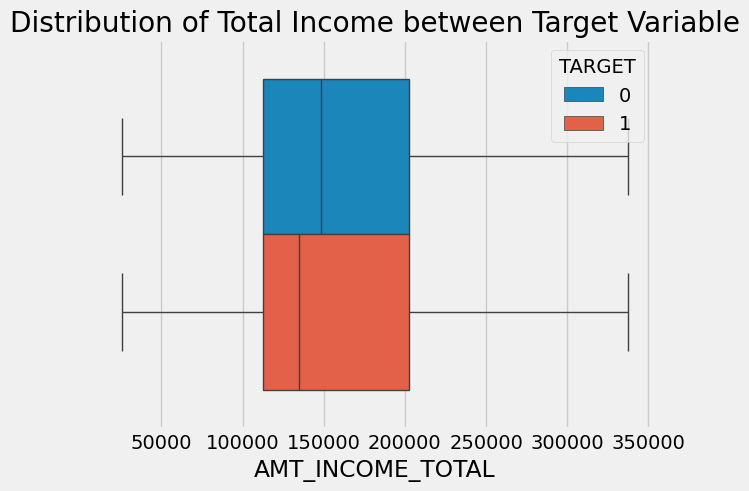

In [34]:
sns.boxplot(x=data['AMT_INCOME_TOTAL'], hue=data['TARGET'], showfliers=False)
plt.title(f'Distribution of Total Income between Target Variable')

**Observation**:
- The countplot of target across total income does not show any significant correlation between these two variables

#### Boxplot of Credit between Target Variable

Text(0.5, 1.0, 'Distribution of Credit between Target Variable')

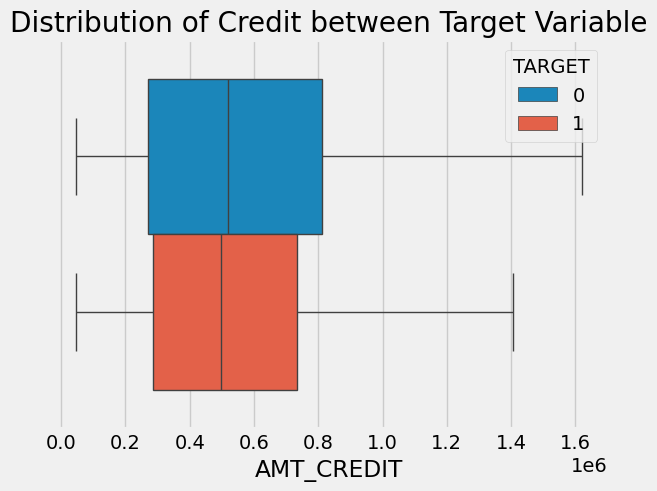

In [35]:
sns.boxplot(x=data['AMT_CREDIT'], hue=data['TARGET'], showfliers=False)
plt.title(f'Distribution of Credit between Target Variable')

**Observation**:
- The countplot of target across credit does not show any significant correlation between these two variables

#### Boxplot of Annuity between Target Variable

Text(0.5, 1.0, 'Distribution of Annuity between Target Variable')

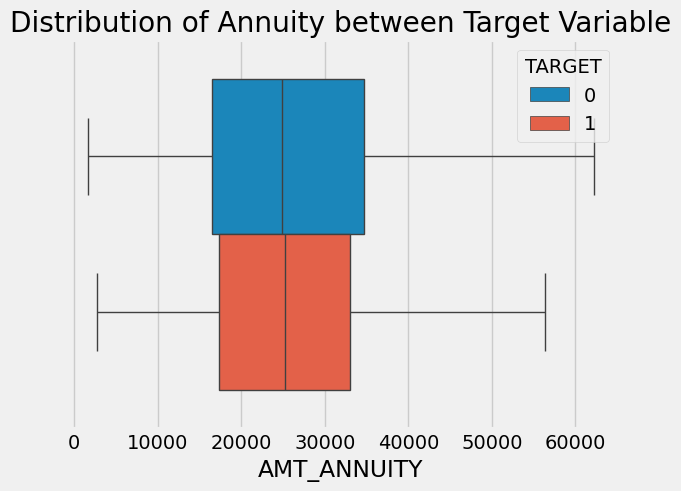

In [36]:
sns.boxplot(x=data['AMT_ANNUITY'], hue=data['TARGET'], showfliers=False)
plt.title(f'Distribution of Annuity between Target Variable')

**Observation**:
- The countplot of target across annuity does not show any significant correlation between these two variables

#### Heatmap of Numerical Variables

Text(0.5, 1.0, 'Heatmap of Numerical Features')

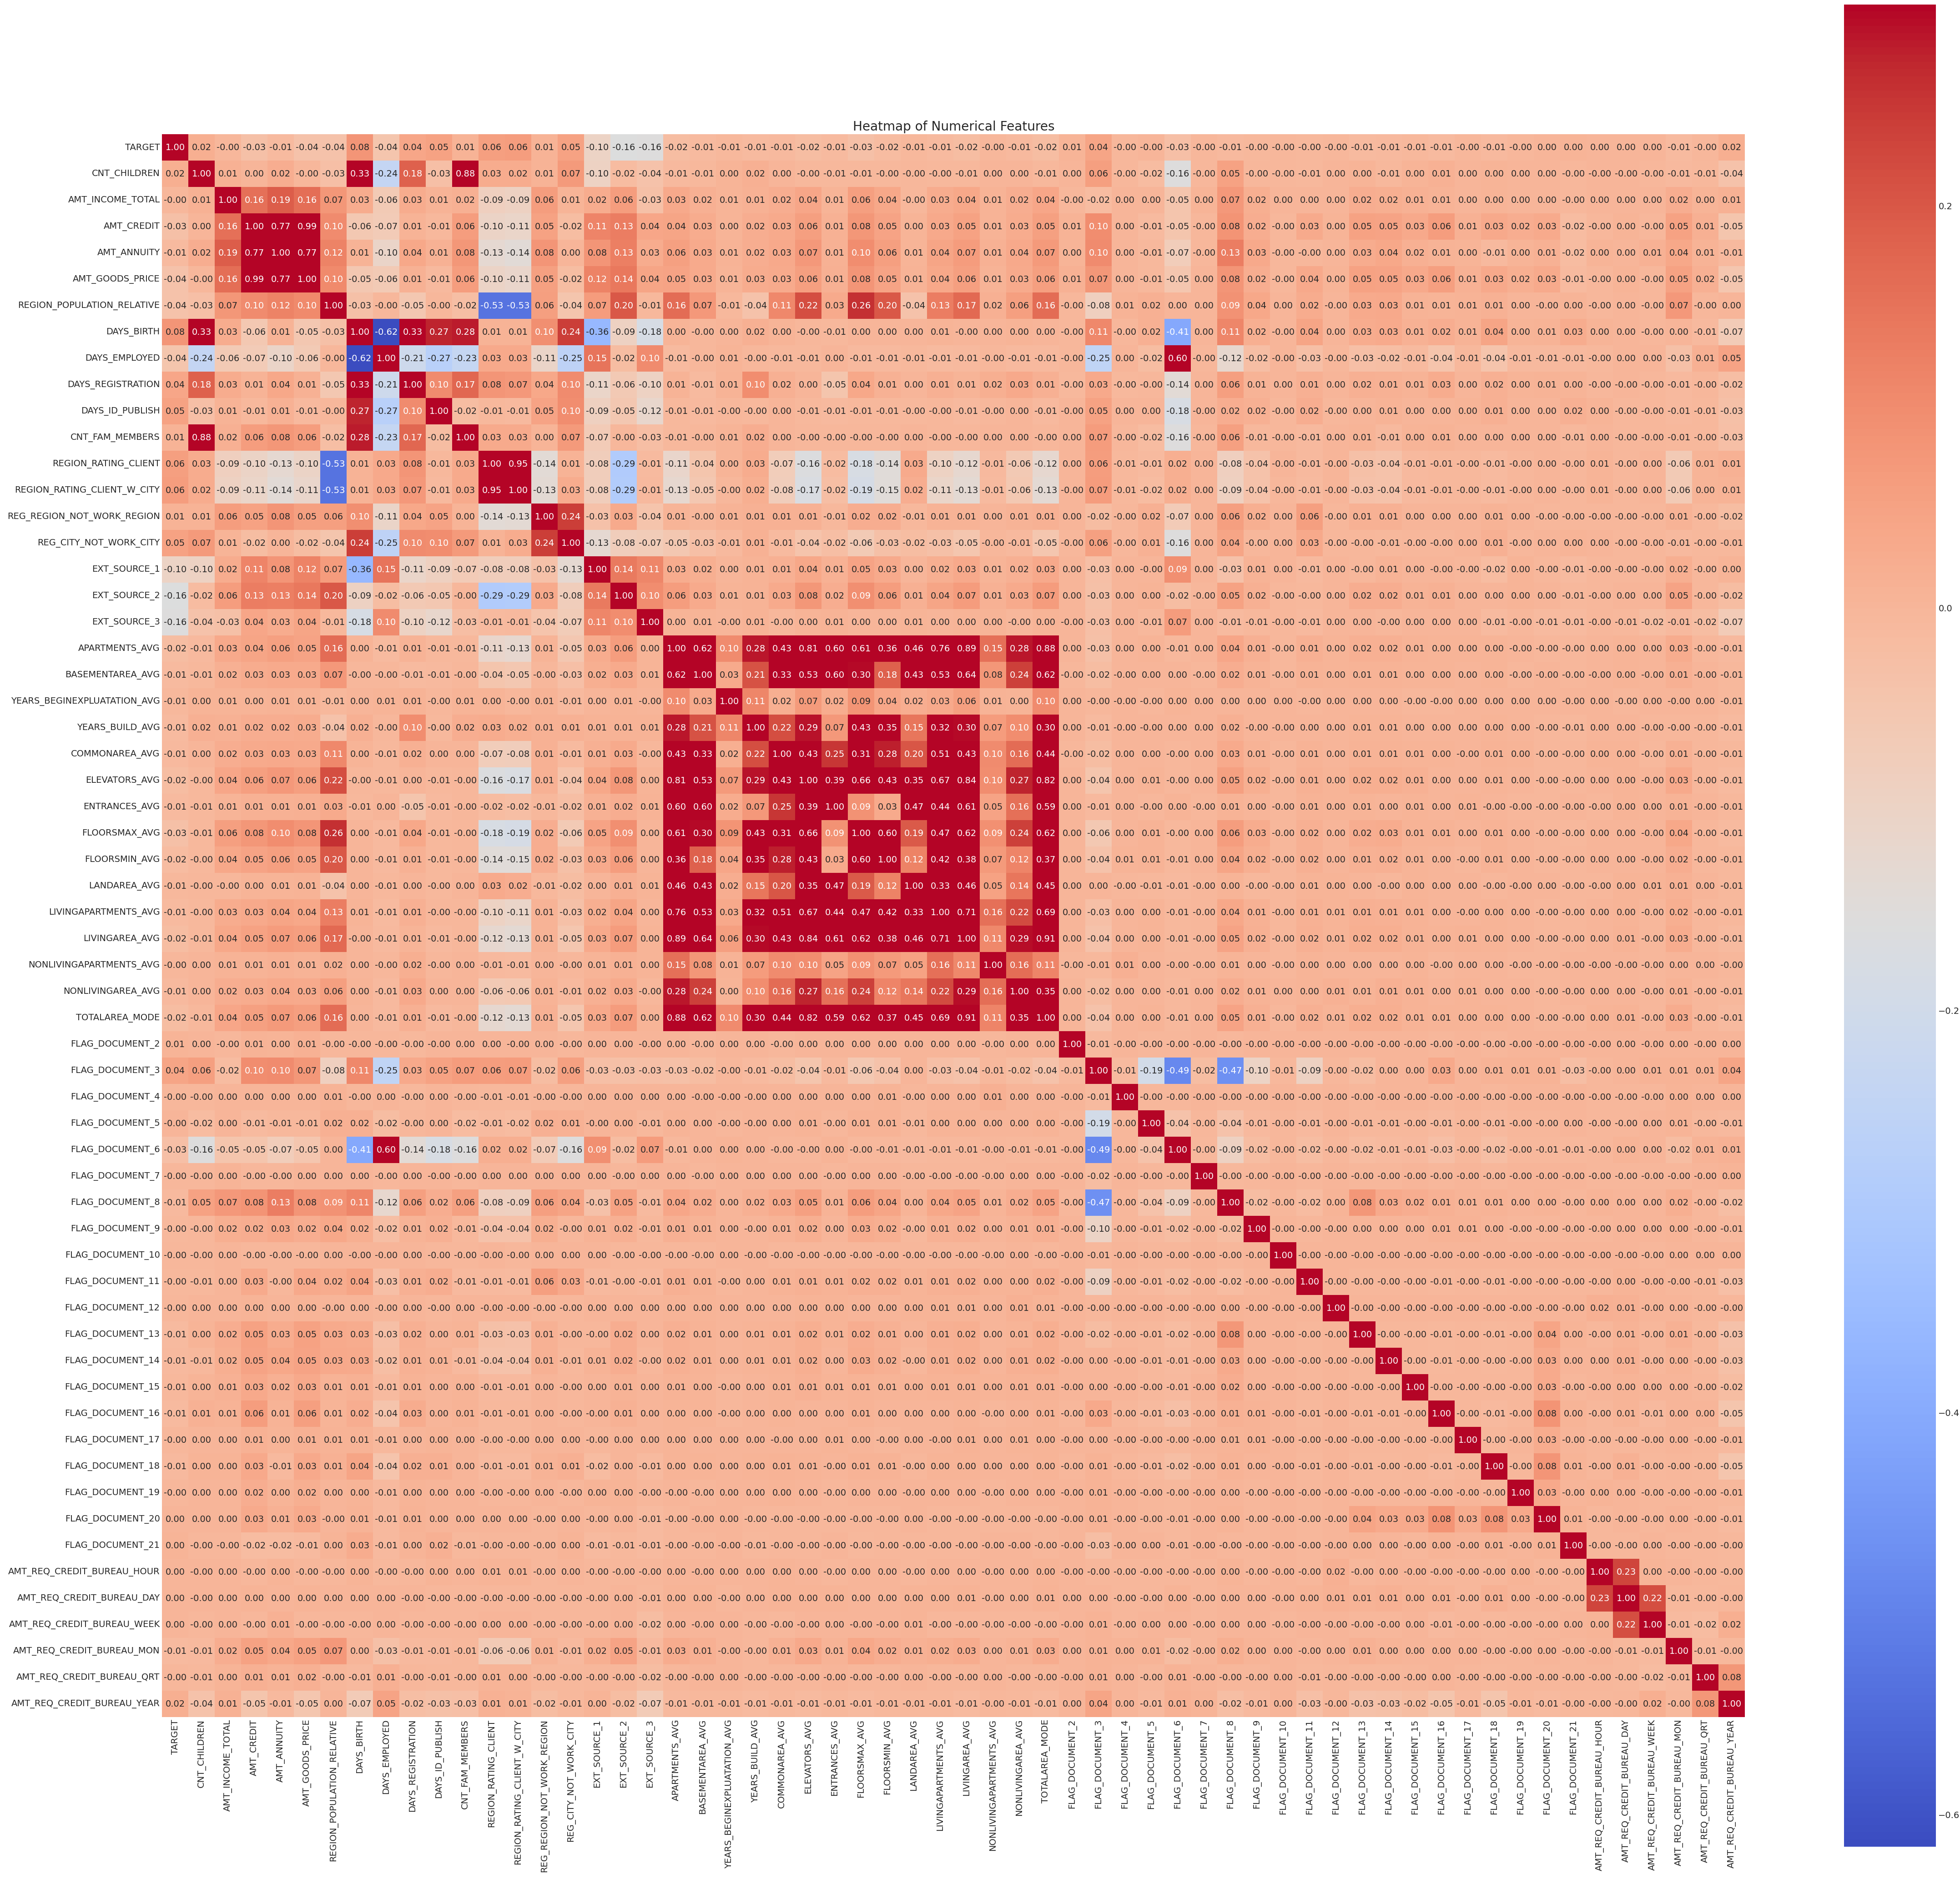

In [37]:
numerical_data = data.select_dtypes(exclude='object')
corr = numerical_data.corr()

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(50, 50))
    ax = sns.heatmap(corr, mask=False, vmax=0.3, square=True, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Heatmap of Numerical Features')

**Observation(s)**:
- AMT_INCOME_TOTAL, AMT_AMMUNITY, AMT_GOODS_PRICE are strongly positively correlated (will drop AMT_AMMUNITY AND AMT_GOODS_PRICE)
- Building specifications are highly correlated so all variables related to building specs will be dropped except for one (APARTMENTS_AVG)
- CNT_CHILDREN AND CNT_FAMILY_MEMBERS are also highly correlated, so CNT_FAM_MEMBERS will be dropped
- There is an interesting positive correlation between DAYS_EMPLOYED AND FLAG_DOCUMENT_6 which suggest that possessing Document 6 indicates a longer employment
- There is an interesting negative correlation betwen DAYS_BIRTH AND FLAG_DOCUMENT_5 which suggest that possessing Document 5 indicates a younger age

In [57]:
# Dropping highly correlated features to reduce dimension size
data.drop(['AMT_ANNUITY',
           'AMT_GOODS_PRICE',
           'BASEMENTAREA_AVG',
           'YEARS_BUILD_AVG',
           'COMMONAREA_AVG',
           'ELEVATORS_AVG',
           'ENTRANCES_AVG',
           'FLOORSMAX_AVG',
           'FLOORSMIN_AVG',
           'LANDAREA_AVG',
           'LIVINGAPARTMENTS_AVG',
           'LIVINGAREA_AVG',
           'NONLIVINGAREA_AVG',
           'TOTALAREA_MODE',
           'CNT_FAM_MEMBERS'],
           axis=1)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,Higher education,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,Cash loans,M,N,N,0,157500.0,254700.0,Working,Secondary / secondary special,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
307507,0,Cash loans,F,N,Y,0,72000.0,269550.0,Pensioner,Secondary / secondary special,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
307508,0,Cash loans,F,N,Y,0,153000.0,677664.0,Working,Higher education,...,0,0,0,0,1.000000,0.000,0.000000,1.000000,0.000000,1.000000
307509,1,Cash loans,F,N,Y,0,171000.0,370107.0,Commercial associate,Secondary / secondary special,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


## **Step 3: Feature Engineering**

Encode the columns that are required for the model

In [128]:
# Apply Label Encoding to encode categorical variables
for col in data.columns:
    if data[col].dtype =='object':
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])

data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0,0,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
307507,0,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
307508,0,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,0,1.000000,0.000,0.000000,1.000000,0.000000,1.000000
307509,1,0,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


Print the percentage of default to a payer of the dataset for the TARGET column

C:\Users\andre\AppData\Local\Temp\ipykernel_21320\1975168849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var.index, y=var.values, palette='bright')


TARGET
0    91.9%
1     8.1%
Name: proportion, dtype: object

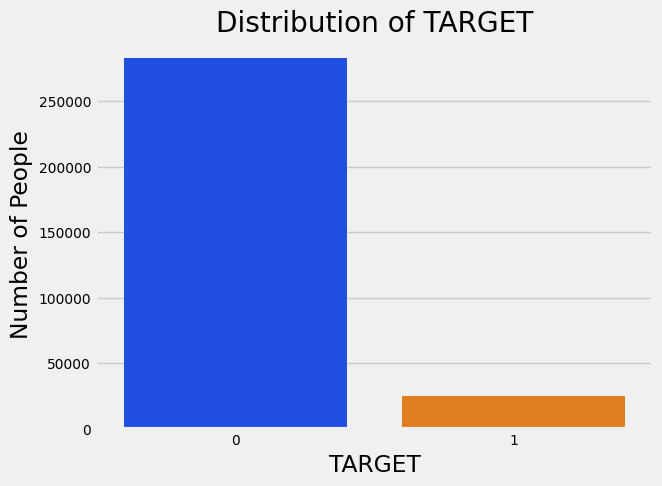

In [126]:
plot_bar('TARGET')

# Percentage of default to a payer for TARGET column
target_normalize = data['TARGET'].value_counts(normalize=True)
round(target_normalize * 100, 1).astype('str') + '%'

**Observation(s)**:
- As seen previously, the datset is highly imbalanced with the majority of clients having a target of 0 (unpaid loan)
- To address the imbalance, SMOTE will be used to upsample the minority class after performing a train-validation split

In [127]:
X = data.drop(columns=['TARGET'], axis=1)
y = data['TARGET']

Perform a Train-Test Split

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [130]:
# Apply SMOTE to unbalanced dataset
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Visualize "Balanced" Dataset after applying SMOTE

In [131]:
y_smote_normalize = y_train_smote.value_counts(normalize=True)
round(y_smote_normalize * 100, 1).astype('str') + '%'

TARGET
0    50.0%
1    50.0%
Name: proportion, dtype: object

Create the DNN model

In [145]:
model = Sequential(
    [Dense(units=256, activation='relu', input_shape=(X_train_smote.shape[-1],)),
    Dense(units=256, activation='relu'),
    Dropout(0.3),
    Dense(units=256, activation='relu'),
    Dropout(0.3),
    Dense(units=1, activation='sigmoid')]
)

Compile the model with Adam optimizer, binary_crossentropy loss, and metrics recall (sensitivity).

In [146]:
model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['recall']
)

Train the model for 50 epochs and batch size 16

In [ ]:
history = model.fit(X_train_smote,
                    y_train_smote,
                    validation_split=0.2,
                    batch_size=10,
                    epochs=10)

Epoch 1/10
42405/42405 ━━━━━━━━━━━━━━━━━━━━ 362s 9ms/step - loss: 59.4946 - recall: 0.4222 - val_loss: 0.6910 - val_recall: 0.0000e+00
Epoch 2/10
42405/42405 ━━━━━━━━━━━━━━━━━━━━ 460s 11ms/step - loss: 0.6932 - recall: 0.4748 - val_loss: 0.6884 - val_recall: 0.0000e+00
Epoch 3/10
42405/42405 ━━━━━━━━━━━━━━━━━━━━ 466s 11ms/step - loss: 0.6932 - recall: 0.5225 - val_loss: 0.6808 - val_recall: 0.0000e+00
Epoch 4/10
42405/42405 ━━━━━━━━━━━━━━━━━━━━ 466s 11ms/step - loss: 0.6932 - recall: 0.5613 - val_loss: 0.6941 - val_recall: 1.0000
Epoch 5/10
42405/42405 ━━━━━━━━━━━━━━━━━━━━ 436s 10ms/step - loss: 0.6932 - recall: 0.4742 - val_loss: 0.7038 - val_recall: 1.0000
Epoch 6/10
42405/42405 ━━━━━━━━━━━━━━━━━━━━ 454s 11ms/step - loss: 0.6932 - recall: 0.4858 - val_loss: 0.6925 - val_recall: 0.0000e+00
Epoch 7/10
42405/42405 ━━━━━━━━━━━━━━━━━━━━ 432s 10ms/step - loss: 0.6932 - recall: 0.4528 - val_loss: 0.6983 - val_recall: 1.0000
Epoch 8/10
42405/42405 ━━━━━━━━━━━━━━━━━━━━ 415s 10ms/step - loss: 

Plot training and validation sensitivity and loss against epochs

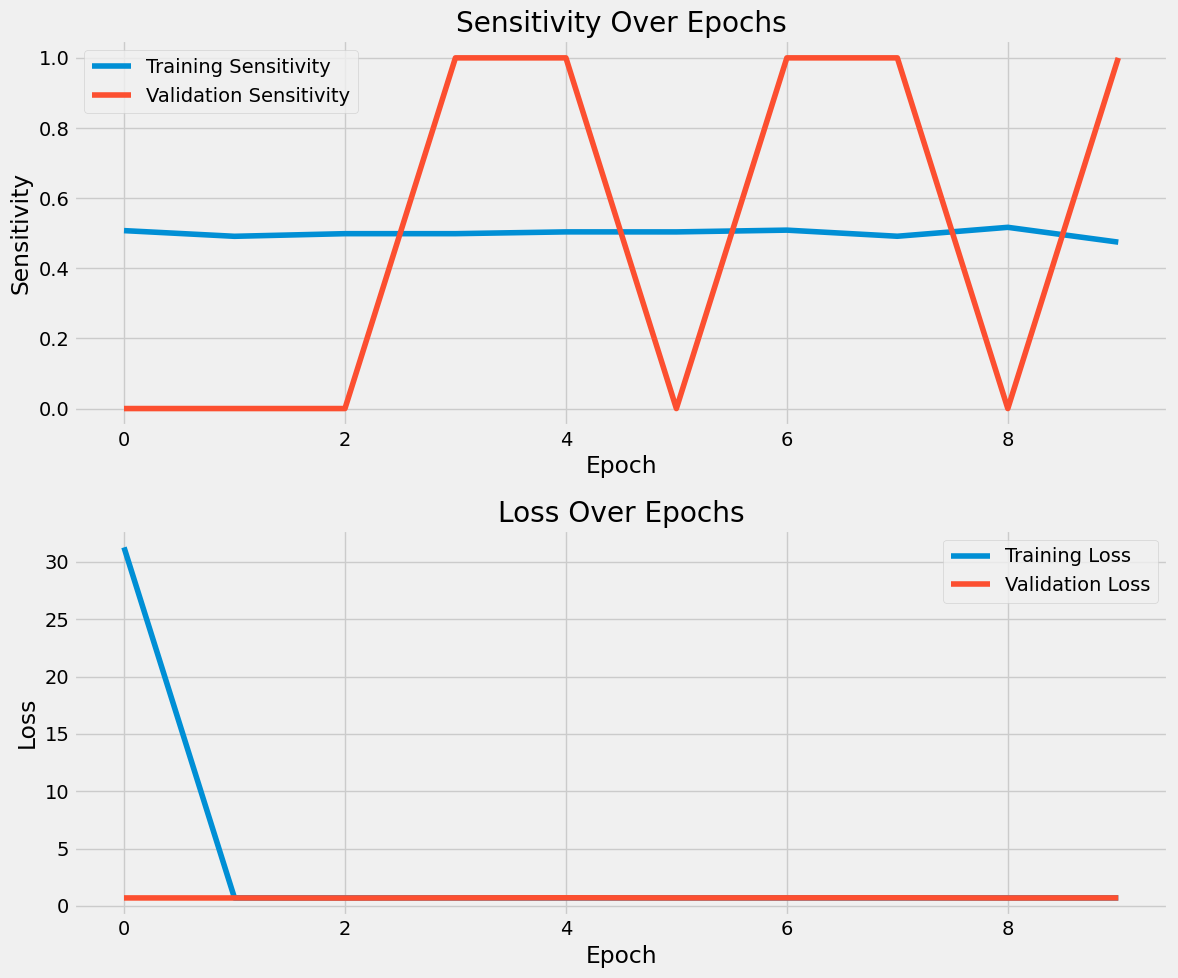

In [149]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Sensitivity Over Epochs')
ax[0].plot(history.history['recall'], label='Training Sensitivity')
ax[0].plot(history.history['val_recall'], label='Validation Sensitivity')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Sensitivity')
ax[0].legend()

ax[1].set_title('Loss Over Epochs')
ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

**Conclusion**: </br>
Sensitivity/Recall represents how many well the model could predict a positive instance over all positive instances. In other words, it is the proportion TP / (TP + FN) where TP is true positive and FN is false negative. After running 10 epochs, recall appeared to converge around 0.5 on the training set but oscillates between 0 and 1 on the validation set, which indicates that the model performs the same as random chance. This indicates underfitting--the poor performance is likely due to the simplicity of the DNN as well as the high dimensionality of the dataset in which there is little to no correlation with the target variable. </br>
It might be beneficial to perform PCA to lower the dimensionality and extract multiple principal components to improve the recall score. In addition, hyperparameter tuning will assist in optimizing the model for this particular dataset.

Compute AUC Score

2403/2403 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step
Test AUC: 0.5


Text(0.5, 0, 'False Positive Rate')

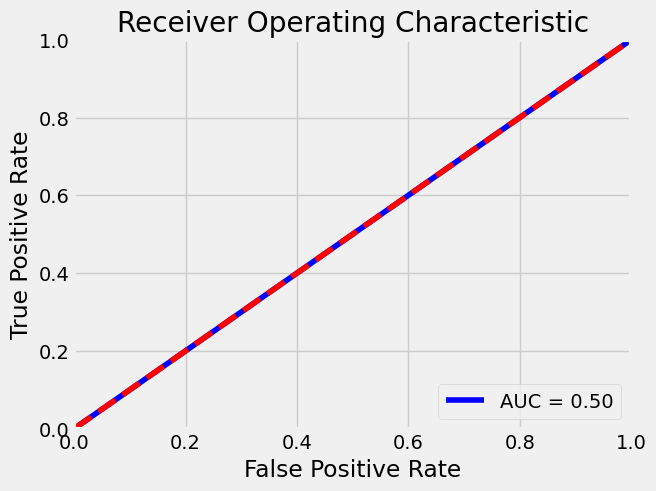

In [153]:
y_pred = model.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print('Test AUC:', roc_auc)

# Plot ROC Curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

**Conclusion**: </br>
The AUC-ROC is 0.5 which indicates that the model is no better than random guessing. As stated previously, it might be beneficial to perform PCA to lower the dimensionality and extract multiple principal components to improve the AUC score. In addition, hyperparameter tuning will assist in optimizing the model for this particular dataset.